In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from reader import Reader


DATASET_NAME = 'atis' # change between 'atis' and 'snips'
reader = Reader(dataset=DATASET_NAME)
df = reader.construct_df_from_dataset(mode='train')
df.head()

,utterance,slots,intent
0,"[i, want, to, fly, from, baltimore, to, dallas...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight
1,"[round, trip, fares, from, baltimore, to, phil...","[B-round_trip, I-round_trip, O, O, B-fromloc.c...",atis_airfare
2,"[show, me, the, flights, arriving, on, baltimo...","[O, O, O, O, O, O, B-toloc.city_name, O, B-arr...",atis_flight
3,"[what, are, the, flights, which, depart, from,...","[O, O, O, O, O, O, O, B-fromloc.city_name, I-f...",atis_flight
4,"[which, airlines, fly, from, boston, to, washi...","[O, O, O, O, B-fromloc.city_name, O, B-toloc.c...",atis_airline


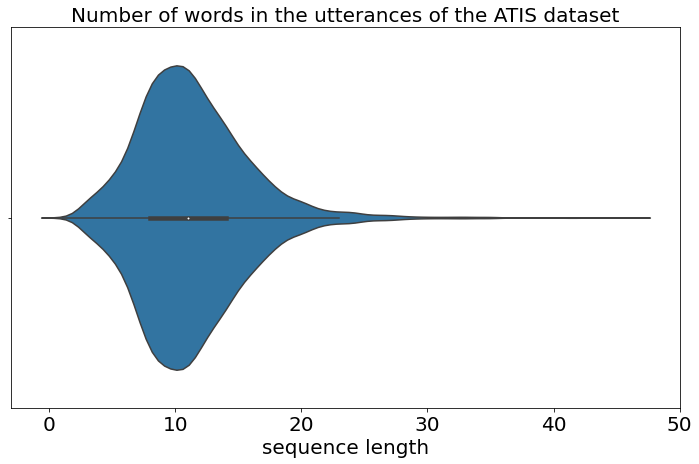

In [123]:
plt.figure(figsize=(12, 7))
chart = sns.violinplot(x=df.utterance.apply(len))
chart.set_xlabel("sequence length")
_ = chart.set_title(f"Number of words in the utterances of the {DATASET_NAME.upper()} dataset")

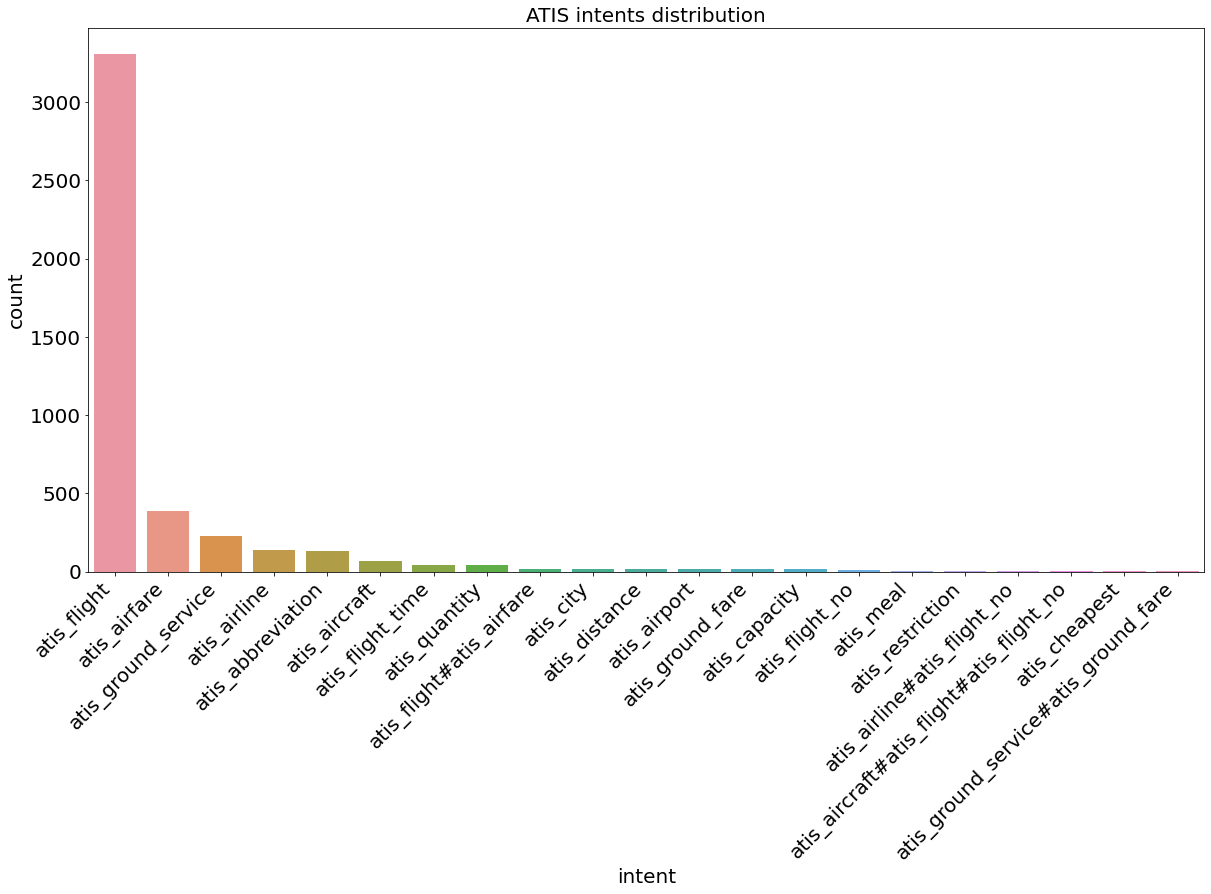

In [124]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
          'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


plt.figure(figsize=(20, 10))
chart = sns.countplot(data=df, x='intent', order=df.intent.value_counts().index)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
#     fontsize='large'
)
# chart.set_yticklabels(
#     chart.get_yticklabels(),
#     fontsize='large'
# )
_ = chart.set_title(f"{DATASET_NAME.upper()} intents distribution")

### Frequent & Rare Slots

In [125]:
lst_tags = df.slots.tolist()

all_tags = [tag for sent_tags in lst_tags for tag in sent_tags]
tags_count = Counter(all_tags)

print("5 Most Common Tags:\n", tags_count.most_common(5), "\n")
print("5 Least Common Tags:\n", tags_count.most_common()[:-6:-1], "\n")

5 Most Common Tags:
 [('O', 32066), ('B-toloc.city_name', 3919), ('B-fromloc.city_name', 3892), ('I-toloc.city_name', 987), ('B-depart_date.day_name', 785)] 

5 Least Common Tags:
 [('I-meal_description', 1), ('B-return_date.today_relative', 1), ('B-stoploc.airport_name', 1), ('I-time', 1), ('B-time_relative', 1)] 



### Average number of words of each slot

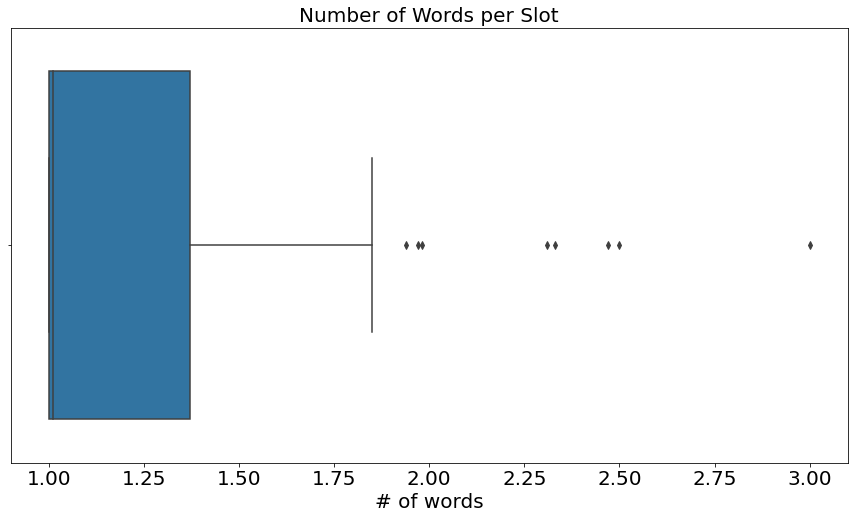

In [126]:
# Find the average number of words for each slot
tag_word_length = {}
for tag in tags_count.keys():
    if tag.startswith('B-'):
        begin_tag_count = tags_count[tag]
        try:
            inside_tag_count = tags_count[f"I-{tag[2:]}"]
        except KeyError:
            continue

        if inside_tag_count == 0:
            tag_word_length[tag[2:]] = 1
            continue

        tag_word_length[tag[2:]] = round(1 + inside_tag_count / begin_tag_count, 2)

# print("Average words per Slot Tag:")
# tag_word_length

plt.figure(figsize=(15, 8))

chart = sns.boxplot(x=list(tag_word_length.values()))
chart.set_xlabel("# of words")
_ = chart.set_title("Number of Words per Slot")

### Relevant Slots per Intent

(Intent) atis_flight, (Relevant Slots): {'mod', 'meal', 'cost_relative', 'fromloc.city_name', 'depart_time.start_time', 'airline_name', 'airline_code', 'stoploc.state_code', 'return_date.day_number', 'arrive_time.time', 'flight_stop', 'fromloc.airport_code', 'arrive_time.end_time', 'flight_days', 'stoploc.airport_name', 'aircraft_code', 'fromloc.state_name', 'flight_time', 'return_date.date_relative', 'flight_mod', 'arrive_time.period_of_day', 'toloc.airport_code', 'depart_date.day_name', 'class_type', 'city_name', 'economy', 'arrive_time.start_time', 'return_date.day_name', 'return_time.period_mod', 'toloc.country_name', 'return_time.period_of_day', 'depart_date.year', 'toloc.state_code', 'meal_description', 'depart_time.end_time', 'flight_number', 'arrive_date.date_relative', 'fare_amount', 'return_date.today_relative', 'arrive_time.time_relative', 'toloc.airport_name', 'toloc.city_name', 'fare_basis_code', 'depart_time.time', 'or', 'depart_date.month_name', 'depart_time.time_relativ

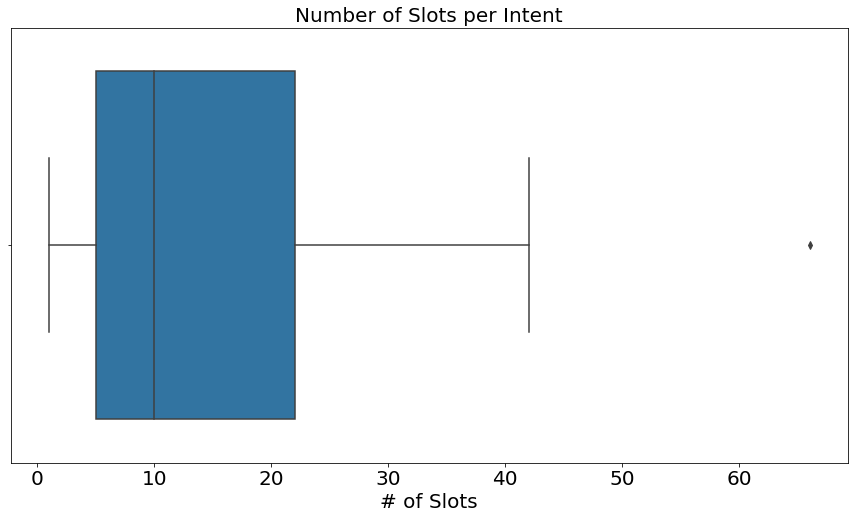

In [127]:
intent_slots_mapping = defaultdict(set)
_, slots, intents = reader.read_dataset(mode='train')
assert len(slots) == len(intents)
for tags, intent in zip(slots, intents):
    for tag in tags:
       if tag != 'O':
            intent_slots_mapping[intent].add(tag[2:])

rel_slots = []
for intent, slots in intent_slots_mapping.items():
    print(f"(Intent) {intent}, (Relevant Slots): {slots}")
    rel_slots.append([intent, len(slots)])

print()
intent_slots_mapping_df = pd.DataFrame(data=rel_slots, columns=['intent', 'n_slots'])
# intent_slots_mapping_df
plt.figure(figsize=(15, 8))

chart = sns.boxplot(x=intent_slots_mapping_df.n_slots)
chart.set_xlabel("# of Slots")
_ = chart.set_title("Number of Slots per Intent")

In [128]:
slot_set = set()
for slots in intent_slots_mapping.values():
    for slot in slots:
        slot_set.add(slot)

print(f"Number of unique slots of the dataset (excluding the Inside Tags!) = {len(slot_set)}")

Number of unique slots of the dataset (excluding the Inside Tags!) = 79


In [129]:
avg_num_slots = df.slots.apply(lambda slots_lst: sum(1 for slot_label in slots_lst if slot_label.startswith('B-'))).values.mean()
print(f"Average number of slots per utterance: {avg_num_slots :.2f}")

Average number of slots per utterance: 3.32


In [130]:
df["num_slots"] = df.slots.apply(lambda slots_lst: sum(1 for slot_label in slots_lst if slot_label.startswith('B-')))
grouped_df = df.groupby('intent').agg(num_slots_per_utter=('num_slots', 'mean'))
grouped_df.reset_index()

intent_count_df = pd.DataFrame(df.intent.value_counts().reset_index())
intent_count_df.columns = ['intent', 'intent_count']

merged_intent_slots_mapping_df = pd.merge(intent_count_df, intent_slots_mapping_df, on='intent')
merged_intent_slots_mapping_df = pd.merge(merged_intent_slots_mapping_df, grouped_df, on='intent')

merged_intent_slots_mapping_df['avg_occurrences_per_slot'] = merged_intent_slots_mapping_df.apply(
    lambda row: row.intent_count * row.num_slots_per_utter / row.n_slots,
    axis=1
)
merged_intent_slots_mapping_df

,intent,intent_count,n_slots,num_slots_per_utter,avg_occurrences_per_slot
0,atis_flight,3309,66,3.575703,179.272727
1,atis_airfare,385,42,3.797403,34.809524
2,atis_ground_service,230,23,1.334783,13.347826
3,atis_airline,139,32,2.201439,9.562500
4,atis_abbreviation,130,11,1.084615,12.818182
5,atis_aircraft,70,22,3.157143,10.045455
6,atis_flight_time,45,20,4.133333,9.300000
7,atis_quantity,41,24,2.487805,4.250000
8,atis_flight#atis_airfare,19,13,3.947368,5.769231
9,atis_city,18,10,1.388889,2.500000


In [131]:
min_support_per_slot = 15
rich_resource_intents = merged_intent_slots_mapping_df[merged_intent_slots_mapping_df.avg_occurrences_per_slot >= min_support_per_slot].intent.tolist()
low_resource_intents = merged_intent_slots_mapping_df[merged_intent_slots_mapping_df.avg_occurrences_per_slot < min_support_per_slot].intent.tolist()

In [132]:
rich_resource_slots = {slot for intent in rich_resource_intents for slot in intent_slots_mapping[intent]}
low_resource_slots = {slot for intent in low_resource_intents for slot in intent_slots_mapping[intent]}

for intent in low_resource_intents:
    num_new_slots = 0
    for slot in (mapping := intent_slots_mapping[intent]):
        if slot not in rich_resource_slots:
            num_new_slots += 1
    print(f"Intent: {intent}, unseen slots: {num_new_slots} out of {len(mapping)}")

Intent: atis_ground_service, unseen slots: 10 out of 23
Intent: atis_airline, unseen slots: 0 out of 32
Intent: atis_abbreviation, unseen slots: 4 out of 11
Intent: atis_aircraft, unseen slots: 0 out of 22
Intent: atis_flight_time, unseen slots: 0 out of 20
Intent: atis_quantity, unseen slots: 0 out of 24
Intent: atis_flight#atis_airfare, unseen slots: 0 out of 13
Intent: atis_city, unseen slots: 1 out of 10
Intent: atis_distance, unseen slots: 0 out of 6
Intent: atis_airport, unseen slots: 1 out of 5
Intent: atis_ground_fare, unseen slots: 1 out of 5
Intent: atis_capacity, unseen slots: 0 out of 5
Intent: atis_flight_no, unseen slots: 0 out of 22
Intent: atis_meal, unseen slots: 0 out of 6
Intent: atis_restriction, unseen slots: 1 out of 6
Intent: atis_airline#atis_flight_no, unseen slots: 0 out of 7
Intent: atis_aircraft#atis_flight#atis_flight_no, unseen slots: 0 out of 5
Intent: atis_cheapest, unseen slots: 0 out of 1
Intent: atis_ground_service#atis_ground_fare, unseen slots: 0 ou

In [133]:
low_resource_slots.issubset(rich_resource_slots)

False

In [134]:
# with open('atis_slots.txt', 'w') as f:
#     for intent in sorted(list(slot_set)):
#         f.write(f"\'{intent}\'\n")

### Error Analysis

In [135]:
# firstly run `main.py` in order to create the csv file
df_test = pd.read_csv(f"{DATASET_NAME}_test_preds.csv")
df_test.head()

,Unnamed: 0,utterance,slots,intent,intent_pred,slots_preds
0,0,"['i', 'would', 'like', 'to', 'find', 'a', 'fli...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fr...",atis_flight,atis_flight,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fr..."
1,1,"['on', 'april', 'first', 'i', 'need', 'a', 'ti...","['O', 'B-depart_date.month_name', 'B-depart_da...",atis_airfare,atis_airfare,"['O', 'B-depart_date.month_name', 'B-depart_da..."
2,2,"['on', 'april', 'first', 'i', 'need', 'a', 'fl...","['O', 'B-depart_date.month_name', 'B-depart_da...",atis_flight,atis_flight,"['O', 'B-depart_date.month_name', 'B-depart_da..."
3,3,"['i', 'would', 'like', 'a', 'flight', 'traveli...","['O', 'O', 'O', 'O', 'O', 'O', 'B-round_trip',...",atis_flight,atis_flight,"['O', 'O', 'O', 'O', 'O', 'O', 'B-round_trip',..."
4,4,"['i', 'would', 'like', 'a', 'flight', 'from', ...","['O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city...",atis_flight,atis_flight,"['O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city..."


In [136]:
df_test["slots"] = df_test.slots.apply(eval)
# df_test["slots"]

In [137]:
df_test.intent.value_counts()

atis_flight                    632
atis_airfare                    48
atis_airline                    38
atis_ground_service             36
atis_abbreviation               33
atis_capacity                   21
atis_airport                    18
atis_flight#atis_airfare        12
atis_distance                   10
atis_aircraft                    9
atis_flight_no                   8
atis_ground_fare                 7
atis_city                        6
atis_meal                        6
atis_quantity                    3
atis_day_name                    2
atis_flight_time                 1
atis_airfare#atis_flight         1
atis_flight#atis_airline         1
atis_flight_no#atis_airline      1
Name: intent, dtype: int64

In [138]:
reader = Reader(DATASET_NAME)
_, slots, intents = reader.read_dataset(mode='test')
slot_labels = reader.get_slot_labels()
intent_labels = reader.get_intent_labels()

# slot_not_found_counter = sum(1 for tag_lst in df_test.slots.tolist() for tag in tag_lst if tag not in slot_labels)
intent_not_found_counter = sum(1 for intent in intents if intent not in intent_labels)
slot_not_found_counter = sum(1 for tag_lst in slots for tag in tag_lst if tag not in slot_labels)
print(f"Number of test set slots that were not found in the training set: {slot_not_found_counter}\n"
      f"Number of test set intents that were not found in the training set {intent_not_found_counter}")


Number of test set slots that were not found in the training set: 6
Number of test set intents that were not found in the training set 0


In [139]:
print(f"Intents not present in the training set: {[intent for intent in intents if intent not in intent_labels]}")
print(f"Slots not present in the training set: {[tag for tag_lst in slots for tag in tag_lst if tag not in slot_labels]}")

Intents not present in the training set: []
Slots not present in the training set: ['I-flight_number', 'B-compartment', 'B-stoploc.airport_code', 'I-state_name', 'B-booking_class', 'B-flight']


In [140]:
from collections import Counter
from transformers import T5Tokenizer
from joint_dataset import SlotDataset

checkpoint = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
train_dataset = SlotDataset(DATASET_NAME, 'train', tokenizer)

dict_lst = []
for utter, tags in zip(train_dataset.sentences, train_dataset.slots):
    slot_dict = SlotDataset.get_clean_slots_dict(utter, tags)
    dict_lst.extend(list(slot_dict.keys()))

slots_counter = Counter(dict_lst)
len(slots_counter)

79

In [141]:
slots_counter

Counter({'fromloc.city_name': 3763,
         'toloc.city_name': 3742,
         'round_trip': 313,
         'cost_relative': 303,
         'fare_amount': 39,
         'arrive_date.month_name': 43,
         'arrive_date.day_number': 43,
         'stoploc.city_name': 216,
         'arrive_time.time_relative': 166,
         'arrive_time.time': 185,
         'toloc.state_code': 76,
         'meal_description': 49,
         'depart_date.month_name': 335,
         'depart_date.day_number': 346,
         'airline_name': 621,
         'depart_time.period_of_day': 474,
         'depart_date.day_name': 750,
         'toloc.state_name': 70,
         'depart_time.time_relative': 276,
         'depart_time.time': 319,
         'toloc.airport_name': 35,
         'depart_date.date_relative': 76,
         'or': 50,
         'airline_code': 121,
         'class_type': 191,
         'fromloc.airport_name': 73,
         'city_name': 202,
         'flight_mod': 283,
         'meal': 43,
         'economy':